# Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset from Kaggle competition challenges you to predict the final price of each home.

# Requirements

- Train, validate (using a dedicated validation set) and submit a linear regression model.
- Train, validate (using a dedicated validation set) and submit a random forest regressor model.
- Achieve a score better than 0.14 on the public leaderboard.

# Evaluation criteria

- Public leaderboard score
- How simple is the model
- Code quality

# Data cleaning

In [206]:
import eli5
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set_theme()
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [207]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [208]:
#msno.bar(train_data, labels=True, fontsize=12);

In [209]:
#msno.bar(test_data, labels=True, fontsize=12);

In the very beginning I have decided entirely drop Alley, PoolQC, Fence and MiscFeature features because majority of values are missing.

In [210]:
features_to_drop = ["Id", "Alley", "PoolArea", "PoolQC", "Fence", "MiscFeature"]
cleaned_train_data = train_data.drop(columns=features_to_drop)
cleaned_test_data = test_data.drop(columns=features_to_drop)

Assuming that majority of lot areas in one neighborhood are more or less similar, I have filled missing values in LotFrontage column by most frequent value of particular neighborhood. 

In [211]:
fill_mode = lambda x: x.value_counts().index[0]

cleaned_train_data["LotFrontage"] = cleaned_train_data["LotFrontage"].fillna(cleaned_train_data.groupby("Neighborhood")["LotFrontage"].transform(fill_mode))
cleaned_test_data["LotFrontage"] = cleaned_test_data["LotFrontage"].fillna(cleaned_test_data.groupby("Neighborhood")["LotFrontage"].transform(fill_mode))

In [212]:
print("Most frequent value in MasVnrType column:", cleaned_train_data["MasVnrType"].mode()[0])
print("Most frequent value in MasVnrAre column:", cleaned_train_data["MasVnrArea"].mode()[0])

Most frequent value in MasVnrType column: None
Most frequent value in MasVnrAre column: 0.0


In [213]:
print("Number of most frequent value in MasVnrType column:", cleaned_train_data[cleaned_train_data["MasVnrType"] == "None"].shape[0])
print("Number of most frequent value in MasVnrAre column:", cleaned_train_data[cleaned_train_data["MasVnrArea"] == 0.0].shape[0])

Number of most frequent value in MasVnrType column: 864
Number of most frequent value in MasVnrAre column: 861


More than a half of values in both MasVnrType and MasVnrAre columns are None or 0.0 respectively. Also I made a technical assumption that masonry type depends on RoofStyle, RoofMatl and Exterior1st or vice versa. So the most frequent values of latter features, which also are values of coresponding rows with missing values in MasVnrType and MasVnrAre columns, are None and 0.0.

In [214]:
cleaned_train_data["MasVnrType"] = cleaned_train_data["MasVnrType"].fillna("None")
cleaned_train_data["MasVnrArea"] = cleaned_train_data["MasVnrArea"].fillna(0.0)

cleaned_test_data["MasVnrType"] = cleaned_test_data["MasVnrType"].fillna("None")
cleaned_test_data["MasVnrArea"] = cleaned_test_data["MasVnrArea"].fillna(0.0)

About 40 values are missing which are related to the features of basement and according to data description file this means that the house has no basement, so I have changed these NA values to None.

In [215]:
basement_features = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]

for feature in basement_features:
    cleaned_train_data[feature] = cleaned_train_data[feature].fillna("None")
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna("None")

Electrical feature's column is missing just one value, so I have replaced it with most frequent value.

In [216]:
cleaned_train_data["Electrical"] = cleaned_train_data["Electrical"].fillna(cleaned_train_data["Electrical"].value_counts().index[0])

NA value in the FireplaceQu column means that house has no fireplace, so I have changed these NA values to None.

In [217]:
cleaned_train_data["FireplaceQu"] = cleaned_train_data["FireplaceQu"].fillna("None")
cleaned_test_data["FireplaceQu"] = cleaned_test_data["FireplaceQu"].fillna("None")

NA values in features which are related to garage also corresponds that house has no garage, so I have changed these NA values to None.

In [218]:
garage_features = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond"]

for feature in garage_features:
    cleaned_train_data[feature] = cleaned_train_data[feature].fillna("None")
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna("None")

## Unbalanced features

In [219]:
def unbalanced_features(table: pd.DataFrame) -> pd.DataFrame:
    """Takes in a table and returns another table with column names 
    and information about most frequent values in those columns."""
    
    feature_names = [column for column in table]
    qty_most_freq_val = [table[column].value_counts().iloc[0] for column in table]
    qty_most_freq_val_perc = [table[column].value_counts().iloc[0] / len(table) * 100 for column in table]
    
    most_freq_val_table = pd.DataFrame({"Feature Name": feature_names, "QTY of most freq. value": qty_most_freq_val,
                                        "% of Total Values": qty_most_freq_val_perc}).sort_values(by="% of Total Values", ascending=False)
    
    return most_freq_val_table

In [220]:
frequent_train_values = unbalanced_features(cleaned_train_data)

In [221]:
frequent_train_values.head()

,Feature Name,QTY of most freq. value,% of Total Values
7,Utilities,1459,99.931507
4,Street,1454,99.589041
12,Condition2,1445,98.972603
67,3SsnPorch,1436,98.356164
43,LowQualFinSF,1434,98.219178


Some features have values which amounts to more than 95 percentage of total values. Such homogeneity is useless for the models so it is better to drop those columns.

In [222]:
frequent_train_features = frequent_train_values[frequent_train_values["% of Total Values"] > 95]["Feature Name"].to_list()

cleaned_train_data = cleaned_train_data.drop(columns=frequent_train_features)
cleaned_test_data = cleaned_test_data.drop(columns=frequent_train_features)

In [223]:
#msno.bar(cleaned_train_data, labels=True, fontsize=12);

## Missing values of test set 

In [224]:
#msno.bar(cleaned_test_data, labels=True, fontsize=12);

Some columns in test set are missing just one or two values, so I have simply filled these missing values with most frequent values in those columns.

In [225]:
missing_test_features = [column for column in cleaned_test_data if cleaned_test_data[column].isna().any() == True]

In [226]:
for feature in missing_test_features:
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna(cleaned_test_data[feature].value_counts().index[0])

In [227]:
#msno.bar(cleaned_test_data, labels=True, fontsize=12);

# Exploratory data analysis

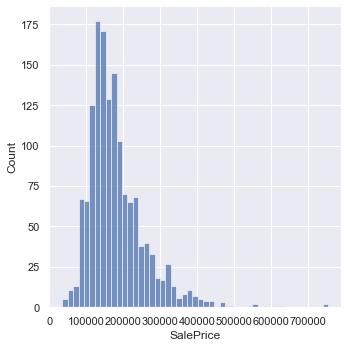

In [228]:
sns.displot(data=cleaned_train_data, x="SalePrice");

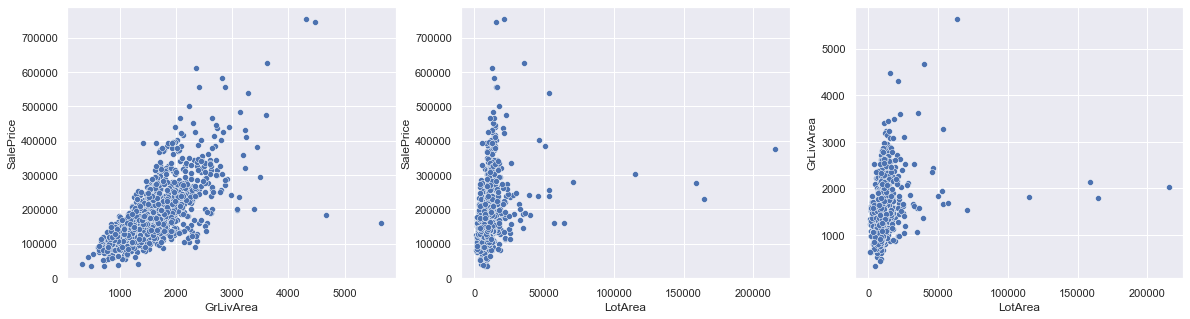

In [229]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
sns.scatterplot(ax=axes[0], data=cleaned_train_data, x="GrLivArea", y="SalePrice")
sns.scatterplot(ax=axes[1], data=cleaned_train_data, x="LotArea", y="SalePrice")
sns.scatterplot(ax=axes[2], data=cleaned_train_data, x="LotArea", y="GrLivArea");

In GrLivArea vs. SalePrice graph are two not logic values where price is very low compared to GrLivArea value. Also in LotArea vs. SalePrice graph are obvious outliers above 100000 LotArea values. So I have decided to remove aforementioned values and after submission linear regression score was almost twice better but random forest score was slightly worse, but it is worth to leave this change due to improvement on linear regression model.

In [230]:
cleaned_train_data.drop(cleaned_train_data[(cleaned_train_data["GrLivArea"] > 4000) & (cleaned_train_data["SalePrice"] < 200000)].index, inplace=True)

In [231]:
cleaned_train_data.drop(cleaned_train_data[cleaned_train_data["LotArea"] > 100000].index, inplace=True)

In [232]:
cleaned_train_data = cleaned_train_data.reset_index().drop(columns="index")

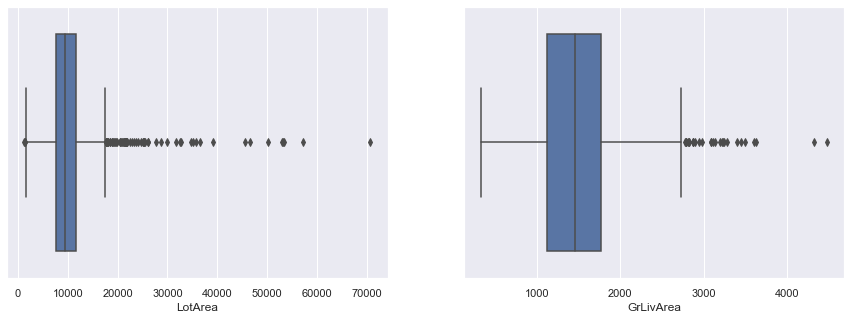

In [233]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(ax=axes[0], x=cleaned_train_data["LotArea"])
sns.boxplot(ax=axes[1], x=cleaned_train_data["GrLivArea"]);

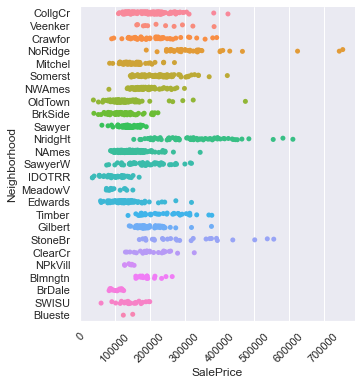

In [234]:
sns.catplot(data=cleaned_train_data, x="SalePrice", y="Neighborhood")
plt.xticks(rotation=45);

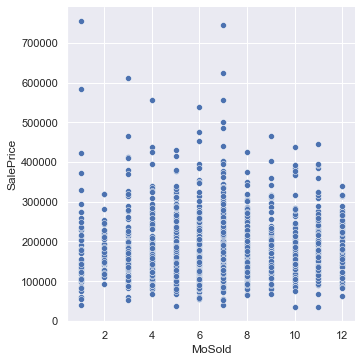

In [235]:
sns.relplot(y="SalePrice", x="MoSold", data=cleaned_train_data);

# Feature engineering

## Feature encoding

### Mapping

Some categorical features have clear order, therefore I have decided to map that values with numbers in sequence. 

In [236]:
train_encoded_data = cleaned_train_data.copy()
test_encoded_data = cleaned_test_data.copy()

In [237]:
train_unbalanced_table = unbalanced_features(train_encoded_data)
frequent_train_features_over_75 = train_unbalanced_table[(train_unbalanced_table["% of Total Values"] > 75) & (train_unbalanced_table["% of Total Values"] < 95)]["Feature Name"].to_list()

print(len(frequent_train_features_over_75))

21


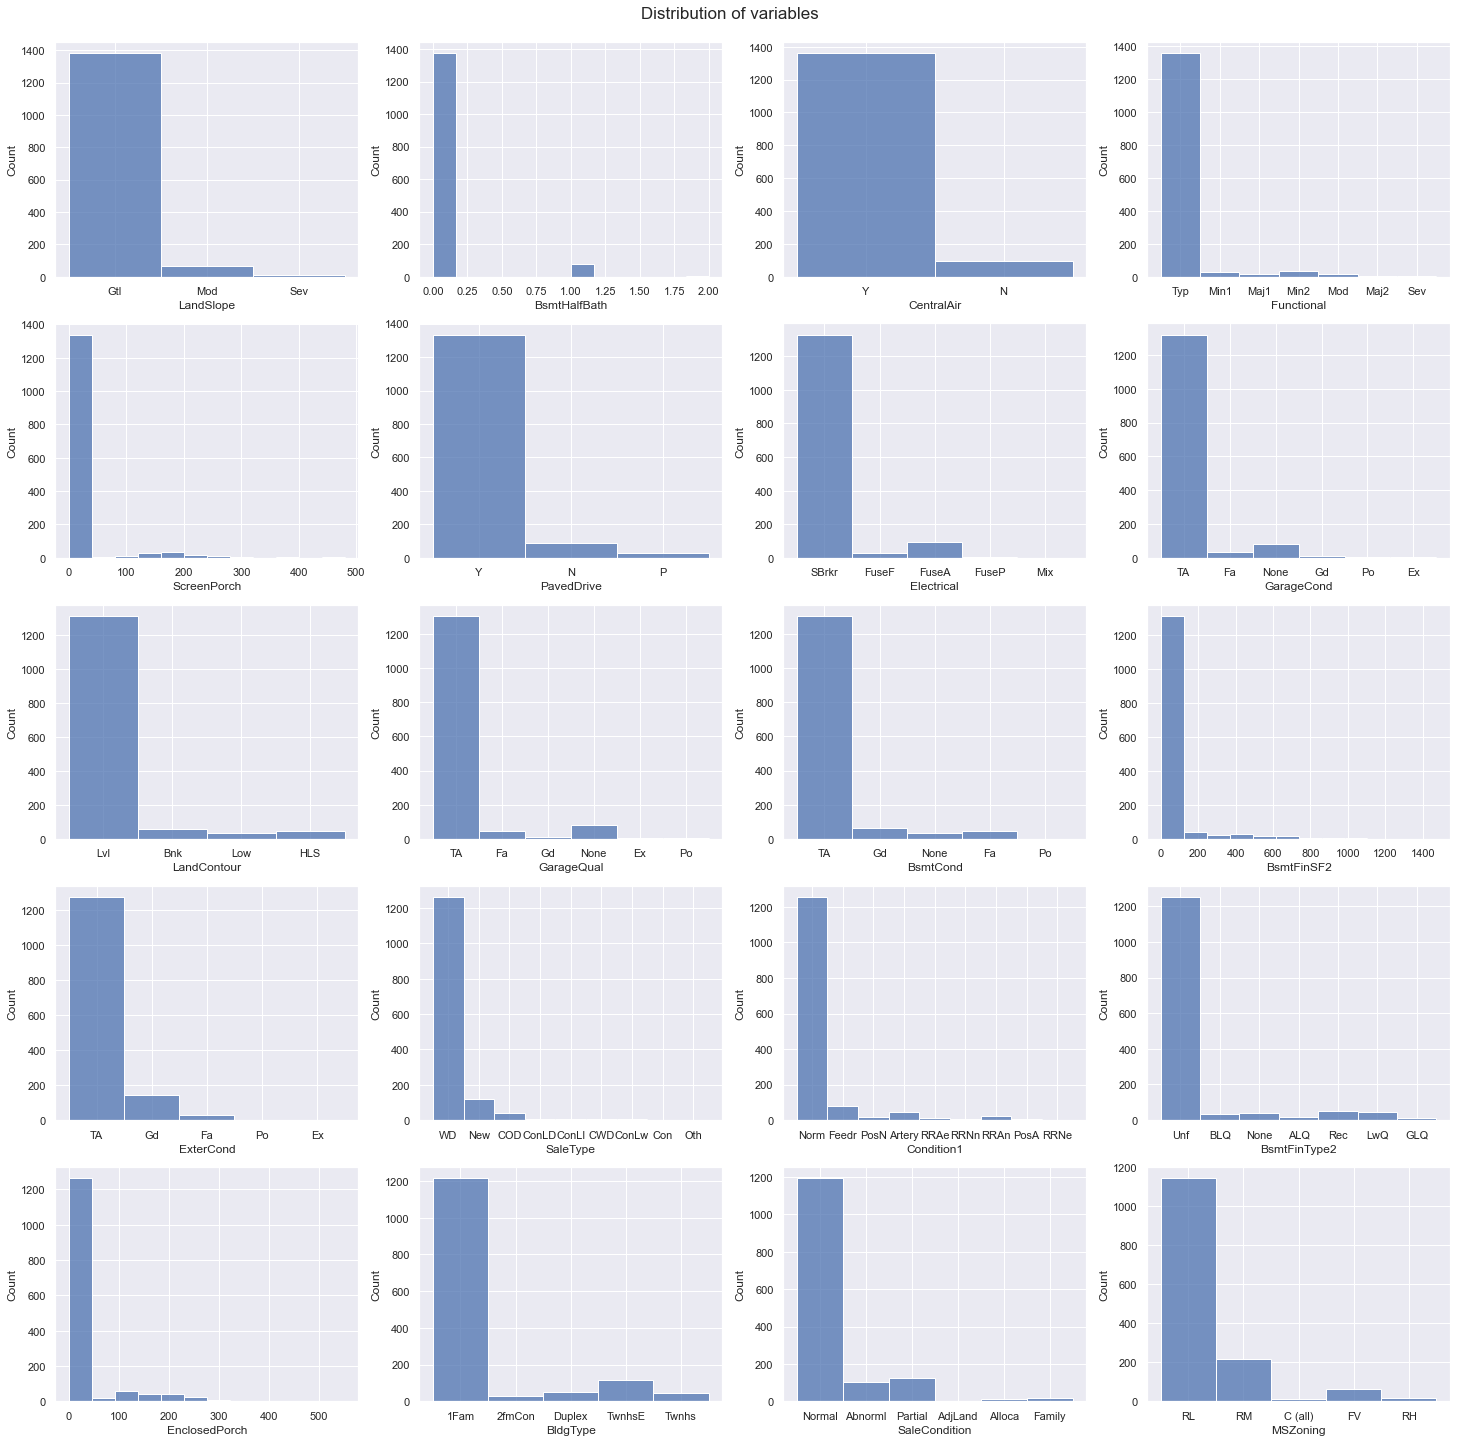

In [238]:
fig, axes = plt.subplots(5, 4, figsize=(25, 25))
fig.suptitle("Distribution of variables", y=0.9, fontsize=17)

for feature, ax in zip(frequent_train_features_over_75, axes.flatten()):
    sns.histplot(ax=ax, data=train_encoded_data, x=feature)

Features that worked:
- Functional
- Electrical
- LandContour
- Condition1
- Exterior1st
- Exterior2nd
- LotShape
- SaleType

Features that didn't work:
- LandSlope
- BsmtHalfBath
- Convert ScreenPorch feature to binary Y/N format
- MSZoning

In [239]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Functional"] = dataset["Functional"].replace(["Min1", "Min2"], "Min")
    dataset["Functional"] = dataset["Functional"].replace(["Maj1", "Maj2"], "Maj")

In [240]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Electrical"] = dataset["Electrical"].replace(["FuseA", "FuseF", "FuseP"], "Fuse")

In [241]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["LandContour"] = dataset["LandContour"].replace("Lvl", "Flat")
    dataset["LandContour"] = dataset["LandContour"].replace(["Bnk", "HLS", "Low"], "NotFlat")

In [242]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Condition1"] = dataset["Condition1"].replace(["RRAn", "RRAe", "RRNn", "RRNe"], "RR")
    dataset["Condition1"] = dataset["Condition1"].replace(["PosN", "PosA"], "Pos")
    dataset["Condition1"] = dataset["Condition1"].replace(["Feedr", "Artery"], "Street")

In [243]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Exterior1st"] = dataset["Exterior1st"].replace(["VinylSd", "MetalSd"], "Sd")
    dataset["Exterior1st"] = dataset["Exterior1st"].replace(["WdShing", "AsbShng", "AsphShn"], "Pos")
    dataset["Exterior1st"] = dataset["Exterior1st"].replace(["CemntBd", "HdBoard"], "Board")
    dataset["Exterior1st"] = dataset["Exterior1st"].replace(["BrkComm", "BrkFace"], "Brick")

In [244]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Exterior2nd"] = dataset["Exterior2nd"].replace(["VinylSd", "MetalSd", "Wd Sdng"], "Sd")
    dataset["Exterior2nd"] = dataset["Exterior2nd"].replace(["Wd Shing", "AsbShng", "AsphShn"], "Pos")
    dataset["Exterior2nd"] = dataset["Exterior2nd"].replace(["CmentBd", "HdBoard"], "Board")
    dataset["Exterior2nd"] = dataset["Exterior2nd"].replace(["BrkComm", "BrkFace"], "Brick")

In [245]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["LotShape"] = dataset["LotShape"].replace(["IR1", "IR2", "IR3"], "IR")

In [246]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["SaleType"] = dataset["SaleType"].replace(["CWD", "VWD"], "WD")
    dataset["SaleType"] = dataset["SaleType"].replace(["ConLw", "ConLD", "ConLI"], "Con")

### Garage feature

In [247]:
quality_mapping = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
quality_features = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "HeatingQC"]

for feature in quality_features:
    train_encoded_data[feature] = train_encoded_data[feature].map(quality_mapping)
    test_encoded_data[feature] = test_encoded_data[feature].map(quality_mapping)

In [248]:
basement_rating_mapping = {"None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
basement_rating_features = ["BsmtFinType1", "BsmtFinType2"]

for feature in basement_rating_features:
    train_encoded_data[feature] = train_encoded_data[feature].map(basement_rating_mapping)
    test_encoded_data[feature] = test_encoded_data[feature].map(basement_rating_mapping)

In [249]:
central_air_mapping = {"N": 0, "Y": 1}
train_encoded_data["CentralAir"] = train_encoded_data["CentralAir"].map(central_air_mapping)
test_encoded_data["CentralAir"] = test_encoded_data["CentralAir"].map(central_air_mapping)

In [250]:
garage_finish_mapping = {"None": 0, "Unf": 1, "RFn": 2, "Fin": 3}
train_encoded_data["GarageFinish"] = train_encoded_data["GarageFinish"].map(garage_finish_mapping)
test_encoded_data["GarageFinish"] = test_encoded_data["GarageFinish"].map(garage_finish_mapping)

In [251]:
ordinal_features = ["SalePrice", "GarageFinish", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "HeatingQC",
                    "BsmtFinType1", "BsmtFinType2", "CentralAir"]

ordinal_data = train_encoded_data[ordinal_features].copy()

After poor results of trying to improve score, I have decided closely to look at mapped features. As I thought not all features which were related to quality correlated with price, that is to say better is not equal higher price, therefore I have to unmap those features. Also I have noticed that GarageQual is highly correlating with GarageCond, so I can delete one of those.

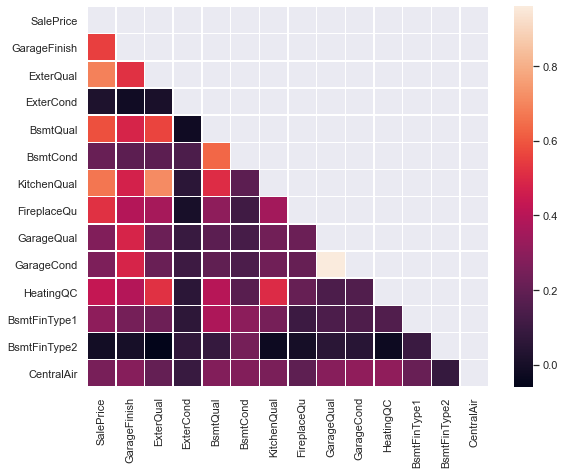

In [252]:
corr = ordinal_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, mask=mask, linewidths=.5);

In [253]:
quality_unmapping = {0: "None", 1: "Po", 2: "Fa", 3: "TA", 4: "Gd", 5: "Ex"}

train_encoded_data["ExterCond"] = train_encoded_data["ExterCond"].map(quality_unmapping)
test_encoded_data["ExterCond"] = test_encoded_data["ExterCond"].map(quality_unmapping)

In [254]:
basement_rating_unmapping = {0: "None", 1: "Unf", 2: "LwQ", 3: "Rec", 4: "BLQ", 5: "ALQ", 6: "GLQ"}

train_encoded_data["BsmtFinType2"] = train_encoded_data["BsmtFinType2"].map(basement_rating_unmapping)
test_encoded_data["BsmtFinType2"] = test_encoded_data["BsmtFinType2"].map(basement_rating_unmapping)

In [255]:
train_encoded_data = train_encoded_data.drop(columns="GarageQual")
test_encoded_data = test_encoded_data.drop(columns="GarageQual")

In [256]:
train_encoded_data["GarageYrBlt"] = train_encoded_data["GarageYrBlt"].replace("None", 0)
test_encoded_data["GarageYrBlt"] = test_encoded_data["GarageYrBlt"].replace("None", 0)

The feature GarageYrBlt itself is not so usefull for modelling because it shouldn't be treated like mere number and it's better to use duration metric.

In [257]:
train_encoded_data["GarageAge"] = train_encoded_data["YrSold"] - train_encoded_data["GarageYrBlt"].astype("int64")
test_encoded_data["GarageAge"] = test_encoded_data["YrSold"] - test_encoded_data["GarageYrBlt"].astype("int64")

train_encoded_data = train_encoded_data.drop(columns="GarageYrBlt")
test_encoded_data = test_encoded_data.drop(columns="GarageYrBlt")

In [258]:
train_encoded_data["YearAge"] = train_encoded_data["YrSold"] - train_encoded_data["YearBuilt"].astype("int64")
test_encoded_data["YearAge"] = test_encoded_data["YrSold"] - test_encoded_data["YearBuilt"].astype("int64")

train_encoded_data = train_encoded_data.drop(columns="YearBuilt")
test_encoded_data = test_encoded_data.drop(columns="YearBuilt")

In [259]:
train_encoded_data = train_encoded_data.drop(columns="MoSold")
test_encoded_data = test_encoded_data.drop(columns="MoSold")

In [260]:
sqrt_features = ["GrLivArea", "TotalBsmtSF", "LotArea", "1stFlrSF", "2ndFlrSF", "MasVnrArea"]
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    for feature in sqrt_features:
        dataset[f"{feature}_Sqrt"] = np.sqrt(dataset[feature])

In [261]:
numerical_features = [column for column in train_encoded_data if (train_encoded_data[column].dtypes == "int64") or (train_encoded_data[column].dtypes == "int64")]
numerical_features.remove("SalePrice")

In [262]:
polynomial = PolynomialFeatures(2, include_bias=False)
polynomial_array = polynomial.fit_transform(train_encoded_data[numerical_features])
polynomial_data = pd.DataFrame(polynomial_array, columns=polynomial.get_feature_names(numerical_features))

In [263]:
features = [column for column in train_encoded_data]

polynomial_data = polynomial_data.drop(columns=features, errors="ignore")

In [264]:
train_encoded_data = train_encoded_data.join(polynomial_data)

### One-hot encoding

In [267]:
categorical_train_features = [column for column in train_encoded_data if train_encoded_data[column].dtypes == "object"]
categorical_test_features = [column for column in test_encoded_data if test_encoded_data[column].dtypes == "object"]

train_oh_encoded_data = pd.get_dummies(train_encoded_data, columns=categorical_train_features)
test_oh_encoded_data = pd.get_dummies(test_encoded_data, columns=categorical_test_features)

In [268]:
print("Train set columns:", train_oh_encoded_data.shape[1])
print("Test set columns:", test_oh_encoded_data.shape[1])

Train set columns: 931
Test set columns: 184


# Modelling

Kaggle submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price, so the corresponding column of train set used to evaluation shuold be in the logarithmic scale too.

In [269]:
# Create sets for cross validation.
train_evaluation_data = train_oh_encoded_data.copy()
train_evaluation_data["SalePrice"] = np.log(train_evaluation_data["SalePrice"])

Test set has fewer columns after one-hot encoding due to unequal number of unique values in categorical features. To tackle this problem I have used pandas align function.  

In [393]:
final_train_data, final_test_data = train_oh_encoded_data.align(test_oh_encoded_data, join='inner', axis=1)

print("Final train set columns:", final_train_data.shape[1])
print("Final test set columns:", final_test_data.shape[1])

Final train set columns: 184
Final test set columns: 184


In [278]:
target = "SalePrice"
final_features = [column for column in train_evaluation_data]
final_features.remove("SalePrice")

X_eval = train_evaluation_data[final_features]
y_eval = train_evaluation_data[target]

#X_train = final_train_data[final_features]
#y_train = train_oh_encoded_data[target]

## Linear regression

In [279]:
linear_regression = LinearRegression()

In [280]:
train_X, val_X, train_y, val_y = train_test_split(X_eval, y_eval, random_state=1)
my_model = LinearRegression().fit(train_X, train_y)

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
865114238.4726 ± 37943436.7219,LotArea TotalBsmtSF
618137480.9684 ± 48429407.4193,LotArea BsmtFinSF1
257978047.5064 ± 21311348.0797,LotArea BsmtUnfSF
82294327.0049 ± 3077352.7793,LotArea BsmtFinSF2
216095.1469 ± 22294.2069,GarageAge
199304.4539 ± 15376.9939,YrSold GarageAge
196931.8283 ± 16495.8764,TotalBsmtSF GrLivArea
121740.1111 ± 11664.9764,BsmtFinSF1 GrLivArea
89152.9632 ± 10201.7302,BsmtUnfSF GrLivArea
74109.4784 ± 7817.7248,BsmtUnfSF YrSold


In [281]:
# Evaluation
linear_scores = cross_val_score(linear_regression, X_eval, y_eval, scoring="neg_root_mean_squared_error")
print("Linear regression RMSE:", linear_scores.mean())

Linear regression RMSE: -1.0607355627498063


In [ ]:
linear_regression.fit(X_train, y_train)
linear_predictions = linear_regression.predict(final_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": linear_predictions})
output.to_csv("submissions/linear_predictions.csv", index=False)

## Ridge regression

In [282]:
ridge_regression = Ridge(alpha=1)

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X_eval, y_eval, random_state=1)
my_model = Ridge(alpha=1).fit(train_X, train_y)

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.1357 ± 0.0194,1stFlrSF_Sqrt
0.0742 ± 0.0084,GrLivArea_Sqrt
0.0713 ± 0.0092,1stFlrSF
0.0488 ± 0.0120,OverallQual
0.0380 ± 0.0085,LotArea_Sqrt
0.0262 ± 0.0045,OverallCond
0.0249 ± 0.0051,YearAge
0.0150 ± 0.0034,MasVnrArea_Sqrt
0.0112 ± 0.0010,TotalBsmtSF
0.0077 ± 0.0041,2ndFlrSF


In [283]:
# Evaluation
ridge_scores = cross_val_score(ridge_regression, X_eval, y_eval, scoring="neg_root_mean_squared_error")
print("Ridge regression RMSE:", ridge_scores.mean())

Ridge regression RMSE: -0.5942285182146935


In [ ]:
ridge_regression.fit(X_train, y_train)
ridge_predictions = ridge_regression.predict(final_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": ridge_predictions})
output.to_csv("submissions/ridge_predictions.csv", index=False)

## Random forest regressor

In [284]:
random_forest = RandomForestRegressor(n_estimators=300)

In [ ]:
my_model = RandomForestRegressor().fit(train_X, train_y)

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.3293 ± 0.0950,OverallQual
0.0512 ± 0.0126,GrLivArea_Sqrt
0.0258 ± 0.0095,GrLivArea
0.0170 ± 0.0075,GarageCars
0.0150 ± 0.0026,BsmtFinSF1
0.0108 ± 0.0020,TotalBsmtSF
0.0095 ± 0.0022,YearAge
0.0094 ± 0.0042,TotalBsmtSF_Sqrt
0.0076 ± 0.0014,FireplaceQu
0.0071 ± 0.0019,1stFlrSF_Sqrt


### Random forest with cross validation

In [285]:
# Evaluation
random_forest_scores = cross_val_score(random_forest, X_eval, y_eval, scoring="neg_root_mean_squared_error")
print("Random forest regressor RMSE:", random_forest_scores.mean())

Random forest regressor RMSE: -0.12637326268368135


In [286]:
random_forest.fit(X_train, y_train)
random_forest_predictions = random_forest.predict(final_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": random_forest_predictions})
output.to_csv("submissions/random_forest_predictions.csv", index=False)

NameError: name 'X_train' is not defined

# Notes

Baseline linear regression model score in notebook: 0.16283
Baseline linear regression model score in Kaggle: 0.34524

Baseline random forest regressor model score in notebook: 0.14265
Baseline random forest regressor model score in Kaggle: 0.14420

Why it is such a big difference of baseline linear regressions model score?

# Fails

### Things which didn't have any improvements to final score.

- Data shuffling - shuffling data before cross validation doesn't improve score.
- train_test_split - score is slightly worse than with cross validation.
- Dealing with outliers - simply removing outliers had better impact for linear regression score and slightly worse result for random forest score.
- Both scaling and normalizing had very poor results for score.